# Notebook 2: Use SageMaker Training Jobs to Accelerate Model Development

## Learning Objectives
- Use SageMaker processing and training jobs to optimize cost and performance
- Compare model performance using SageMaker Experiments
- Deploy a model as an endpoint for real-time inference

## Environment Notes:
This notebook was created and tested on an `ml.t3.medium (2 vCPU + 4 GiB)` notebook instance running the `Python 3.0 (Data Science)` kernel in SageMaker Studio.

## Table of Contents
1. [Background](#1.-Background)
    1. [SageMaker Jobs](#1.1.-SageMaker-Jobs)
    1. [SageMaker Experiments](#1.2.-SageMaker-Experiments)
1. [Preparation](#2.-Preparation)
    1. [Import Python libraries](#2.1.-Import-Python-Libraries)
    1. [Create Some Necessary Clients](#2.2.-Create-some-necessary-clients)
    1. [Create an Experiment](#2.3.-Create-an-experiment)
    1. [Specify S3 Bucket and Prefix](#2.4.-Specify-S3-bucket-and-prefix)
    1. [Define Local Working Directories](#2.5.-Define-local-working-directories)
1. [Data Preparation with Amazon SageMaker Processing](#3.-Data-Preparation-with-Amazon-SageMaker-Processing)
    1. [Submit SageMaker Processing Job](#3.1.-Submit-SageMaker-Processing-Job)
    1. [Download Processed Data from S3](#3.2.-Download-Processed-Data-from-S3)
1. [Model Training](#4.-Model-Training)
    1. [Train Model Using a SKLearn Random Forest Algorithm](#4.1.-Train-Model-Using-a-SKLearn-Random-Forest-Algorithm)
    1. [Train Model using a Keras MLP](#4.2.-Train-Model-using-a-Keras-MLP)
    1. [Train Model Using the XGBoost Algorithm](#4.3.-Train-Model-Using-the-XGBoost-Algorithm)
1. [Model Evaluation](#5.-Model-Evaluation)
    1. [Download and Run the Trained XGBoost Model](#5.1.-Download-and-Run-the-Trained-XGBoost-Model)
    1. [Compare Model Results Using SageMaker Experiments](#5.2.-Compare-Model-Results-Using-SageMaker-Experiments)
1. [Deploy](#6-Deploy)
    1. [Deploy Model as a SageMaker Endpoint](#6.1.-Deploy-Model-as-a-SageMaker-Endpoint)
    1. [Test Endpoint](#6.2.-Test-Endpoint)
    1. [Clean Up](#6.3.-Clean-Up)

---

## 1. Background
In notebook 1 of this series, we demonstrated using RNAseq data to predict HER2 status using the compute resources on the notebook server. However, using notebook server resources to process large amounts of data or train complex models is generally not a good idea. It's possible to scale up your notebook server, but any time you spend on non-compute intensive tasks (i.e. most of your time) will be wasted. A better idea is to run your notebook on a small server and submit compute-intensive tasks to independent jobs. SageMaker provides managed services for running data processing, model training, and hyperparameter tuning jobs. In this notebook, we'll demonstrate how to leverage these services to optimize the performance and cost of our tasks.

Specifically, we'll demonstrate two best practices: **Jobs** and **Experiments**.

These best practices play a key role in the **Prepare Data** and **Model Development** phases of the Machine Learning Lifecycle. For more information, please refer to the [Machine Learning Best Practices in Healthcare and Life Sciences Whitepaper](https://d1.awsstatic.com/whitepapers/ML-best-practices-health-science.pdf?did=wp_card&trk=wp_card).

![Machine Learning Life Cycle - Part 1](img/MLLC1.png "ML Life Cycle - Part 1")

---

## 1.1. SageMaker Jobs

[SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html) processing, training, and hyperparameter optimization (HPO) jobs allow data scientists to submit compute-heavy processes to external services. This keeps costs optimized and ensures that these tasks run in reproducible environments. It also improves data scientist productivity by allowing these jobs to run in "the background" and provides resiliancy if something happens to your notebook environment.

![alt text](img/jobs.png "Jobs")

## 1.2. SageMaker Experiments

![alt text](img/experiments.png "Experiments")

[SageMaker Experiments](https://aws.amazon.com/blogs/aws/amazon-sagemaker-experiments-organize-track-and-compare-your-machine-learning-trainings) make it as easy as possible to track data preparation and analysis steps. Organizing your ML project into experiments helps you manage large numbers of trials and alternative algorithms. Experiments also ensure that any artifacts your generate for production use can be traced back to their source.

---
## 2. Preparation

Let's start by specifying:

- The Python libraries that we'll use throughout the analysis
- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

### 2.1. Import Python Libraries

In [ ]:
%pip install --disable-pip-version-check -U -q -r requirements.txt

In [24]:
import boto3
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sagemaker
from sagemaker.analytics import ExperimentAnalytics
from sagemaker.processing import ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.tensorflow import TensorFlow
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score
from smexperiments.experiment import Experiment
from smexperiments.search_expression import Filter, Operator, SearchExpression
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from time import strftime, sleep
import xgboost as xgb

### 2.2. Create Some Necessary Clients

In [ ]:
boto_session = boto3.session.Session()
region = boto_session.region_name
sagemaker_session = sagemaker.session.Session(boto_session)
sagemaker_execution_role = sagemaker.session.get_execution_role(sagemaker_session)
sagemaker_boto_client = boto_session.client("sagemaker")
s3_boto_client = boto_session.client("s3")
account_id = boto_session.client("sts").get_caller_identity().get("Account")
print(f"Assumed SageMaker role is {sagemaker_execution_role}")

### 2.3. Create an Experiment

We create a new SageMaker experiment specific to our scientific goal, in this case to predict HER2 status.

In [5]:
create_date = strftime("%Y-%m-%d-%H-%M-%S")
brca_her2_experiment = Experiment.create(
    description="Predict HER2 status using TCGA RNAseq data.",
    experiment_name=f"BRCA-HER2-{create_date}",
    sagemaker_boto_client=sagemaker_boto_client,
    tags=[{"Key": "Creator", "Value": "arosalez"}],
)

### 2.4. Specify S3 Bucket and Prefix

In [ ]:
S3_BUCKET = sagemaker_session.default_bucket()
S3_PREFIX = "brca-her2-classifier"
S3_PATH = sagemaker.s3.s3_path_join(S3_BUCKET, S3_PREFIX)
print(f"S3 path is {S3_PATH}")

### 2.5. Define Local Working Directories

In [ ]:
WORKING_DIR = os.getcwd()
DATA_DIR = os.path.join(WORKING_DIR, "data")
print(f"Working directory is {WORKING_DIR}")
print(f"Data directory is {DATA_DIR}")

---
## 3. Data Preparation  with Amazon SageMaker Processing

Amazon SageMaker Processing allows you to run steps for data pre- or post-processing, feature engineering, data validation, or model evaluation workloads on Amazon SageMaker. Processing jobs accept data from Amazon S3 as input and store data into Amazon S3 as output.

![processing](https://sagemaker.readthedocs.io/en/stable/_images/amazon_sagemaker_processing_image1.png)

Here, we'll import the dataset and transform it with SageMaker Processing, which can be used to process terabytes of data in a SageMaker-managed cluster separate from the instance running your notebook server. In a typical SageMaker workflow, notebooks are only used for prototyping and can be run on relatively inexpensive and less powerful instances, while processing, training and model hosting tasks are run on separate, more powerful SageMaker-managed instances.  SageMaker Processing includes off-the-shelf support for Scikit-learn, as well as a Bring Your Own Container option, so it can be used with many different data transformation technologies and tasks.    

To use SageMaker Processing, simply supply a Python data preprocessing script as shown below.  For this example, we're using a SageMaker prebuilt Scikit-learn container, which includes many common functions for processing data.  There are few limitations on what kinds of code and operations you can run, and only a minimal contract:  input and output data must be placed in specified directories.  If this is done, SageMaker Processing automatically loads the input data from S3 and uploads transformed data back to S3 when the job is complete.

For this example, we'll download the raw data directly from Xenahubs as part of the processing script, so we do not need to specify an input bucket.

### 3.1. Submit SageMaker Processing Job

This will take about 5 minutes to complete. Notice that this code block references `scripts/processing/processing.py`. The processing job will run this script on a different compute instance, in this case a ml.m5.xlarge. This allows us to use a small instance for our notebook server, while still taking advantage of a more powerful instance for the processing.

In [ ]:
HISEQ_URL = "https://tcga.xenahubs.net/download/TCGA.BRCA.sampleMap/HiSeqV2_PANCAN.gz"
BRCA_CLINICAL_MATRIX_URL = (
    "https://tcga.xenahubs.net/download/TCGA.BRCA.sampleMap/BRCA_clinicalMatrix"
)

sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    role=sagemaker_execution_role,
    sagemaker_session=sagemaker_session,
)

processing_run_name = f"data-processing-job-{strftime('%Y-%m-%d-%H-%M-%S')}"

sklearn_processor.run(
    job_name=processing_run_name,
    code="scripts/processing/processing.py",
    outputs=[
        ProcessingOutput(
            output_name="train",
            source="/opt/ml/processing/output/train",
            destination=f"s3://{S3_BUCKET}/{S3_PREFIX}/data/train/",
        ),
        ProcessingOutput(
            output_name="validation",
            source="/opt/ml/processing/output/val",
            destination=f"s3://{S3_BUCKET}/{S3_PREFIX}/data/val/",
        ),
        ProcessingOutput(
            output_name="test",
            source="/opt/ml/processing/output/test",
            destination=f"s3://{S3_BUCKET}/{S3_PREFIX}/data/test/",
        ),
    ],
    arguments=[
        "--brca_clinical_matrix_url",
        BRCA_CLINICAL_MATRIX_URL,
        "--hiseq_url",
        HISEQ_URL,
        "--train_test_split_ratio",
        "0.2",
        "--gene_count",
        "20000",
        "--create_test_data",
    ],
    experiment_config={
        "ExperimentName": brca_her2_experiment.experiment_name,
        "TrialComponentDisplayName": processing_run_name,
    },
    wait=True,
)

### 3.2. Download Processed Data from S3

In [9]:
sagemaker_session.download_data(
    f"{DATA_DIR}/output/train",
    bucket=S3_BUCKET,
    key_prefix=f"{S3_PREFIX}/data/train/train.csv",
)
sagemaker_session.download_data(
    f"{DATA_DIR}/output/val",
    bucket=S3_BUCKET,
    key_prefix=f"{S3_PREFIX}/data/val/val.csv",
)
sagemaker_session.download_data(
    f"{DATA_DIR}/output/test",
    bucket=S3_BUCKET,
    key_prefix=f"{S3_PREFIX}/data/test/test.csv",
)

---
## 4. Model Training

Now that our training data is set up, we can train some models. To highlight the benefits of experiment tracking, we're going to train models using three different frameworks:
- The random forest model from Scikit Learm
- A multi-layer perceptron (MLP) neural network in Keras
- The open-source XGBoost algorithm

Since we're using SageMaker jobs to run our training, we don't need to install any additional libraries or spin up expensive compute resources on our notebook server. The jobs use their own dependencies and we're only charged for the time they run.

First, let's define some variables that all three training jobs will need.

In [10]:
# define the data type and paths to the training and validation datasets
content_type = "text/csv"

s3_input_train = sagemaker.inputs.TrainingInput(
    f"s3://{S3_BUCKET}/{S3_PREFIX}/data/train/train.csv", content_type=content_type
)

s3_input_validation = sagemaker.inputs.TrainingInput(
    f"s3://{S3_BUCKET}/{S3_PREFIX}/data/val/val.csv", content_type=content_type
)

model_output_path = f"s3://{S3_BUCKET}/{S3_PREFIX}/models/"

### 4.1. Train Model Using a SKLearn Random Forest Algorithm

Create a trial

In [11]:
rf_trial = Trial.create(
    experiment_name=brca_her2_experiment.experiment_name,
    sagemaker_boto_client=sagemaker_boto_client,
    trial_name=f"RF-Trial-{strftime('%Y-%m-%d-%H-%M-%S')}",
)

Here again we're passing a script (`scripts/rf_train/rf_train.py`) to run during the training job. Notice that we've also included a `requirements.txt` file in the training script directory to install additional dependencies in the training container. This is a great way to install an extra package or two without creating your own container image from scratch!

Setting `wait=False` allows us to continue running the notebook while the training job runs in "the background" (on a different machine).

In [12]:
rf_job_name = f"RF-Training-Job-{strftime('%Y-%m-%d-%H-%M-%S')}"

rf_estimator = SKLearn(
    base_job_name=rf_job_name,
    enable_sagemaker_metrics=True,
    entry_point="rf_train.py",
    framework_version="0.23-1",
    hyperparameters={
        "n-estimators": 100,
        "min-samples-leaf": 3,
    },
    instance_count=1,
    instance_type="ml.c5.xlarge",
    output_path=model_output_path,
    role=sagemaker_execution_role,
    sagemaker_session=sagemaker_session,
    source_dir="scripts/rf_train",
)

rf_estimator.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    experiment_config={
        "TrialComponentDisplayName": rf_job_name,
        "TrialName": rf_trial.trial_name,
    },
    job_name=rf_job_name,
    wait=False,
)

INFO:sagemaker:Creating training-job with name: RF-Training-Job-2022-12-16-15-05-43


Note that you can also run the same training script in the notebook, as long as you have the dependencies installed!

In [13]:
# if not os.path.exists("models"):
#     os.makedirs("models")

# !python scripts/rf_train/rf_train.py --n-estimators 100 \
#                    --min-samples-leaf 3 \
#                    --model-dir models \
#                    --train "data/output/train" \
#                    --validation "data/output/val" \
#                    --test "data/output/test"

---

### 4.2. Train Model using a Keras MLP

Create a trial

In [14]:
tf_trial = Trial.create(
    experiment_name=brca_her2_experiment.experiment_name,
    sagemaker_boto_client=sagemaker_boto_client,
    trial_name=f"TF-Trial-{strftime('%Y-%m-%d-%H-%M-%S')}",
)

Submit the training job

In [15]:
tf_job_name = f"TF-Training-Job-{strftime('%Y-%m-%d-%H-%M-%S')}"

tf_estimator = TensorFlow(
    enable_sagemaker_metrics=True,
    entry_point="tf_train.py",
    framework_version="2.2",
    instance_count=1,
    instance_type="ml.c5.xlarge",
    metric_definitions=[
        {"Name": "validation:accuracy", "Regex": "Validation Accuracy: ([0-9.]+)$"},
        {"Name": "validation:precision", "Regex": "Validation Precision: ([0-9.]+)$"},
        {"Name": "validation:f1", "Regex": "Validation F1 Score: ([0-9.]+)$"},
    ],
    output_path=model_output_path,
    py_version="py37",
    role=sagemaker_execution_role,
    sagemaker_session=sagemaker_session,
    source_dir="scripts/tf_train",
)

tf_estimator.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    experiment_config={
        "TrialComponentDisplayName": tf_job_name,
        "TrialName": tf_trial.trial_name,
    },
    job_name=tf_job_name,
    wait=False,
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: TF-Training-Job-2022-12-16-15-05-44


### 4.3. Train Model Using the XGBoost Algorithm

Compare the XGBoost training script we're about to run (scripts/rf_train/rf_train.py) with the training function we used in Notebook 1. You'll notice that the `xgb.train` call is the same in both!

Since we're setting `wait=True` our Jupyter session will wait until this training job is finished before moving on

Create a trial

In [16]:
xgb_trial = Trial.create(
    experiment_name=brca_her2_experiment.experiment_name,
    sagemaker_boto_client=sagemaker_boto_client,
    trial_name=f"XGBoost-Trial-{strftime('%Y-%m-%d-%H-%M-%S')}",
)

Submit the training job

In [ ]:
xgb_job_name = f"XGB-Training-Job-{strftime('%Y-%m-%d-%H-%M-%S')}"

framework_version = "1.2-1"
py_version = "py3"

hyper_params_dict = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "error",
    "scale_pos_weight": 9.0,
    "max_depth": 3,
    "min_child_weight": 5,
    "subsample": 0.9,
    "verbosity": 1,
    "tree_method": "auto",
}

xgb_estimator = XGBoost(
    enable_sagemaker_metrics=True,
    entry_point="xgb_train.py",
    framework_version=framework_version,
    hyperparameters=hyper_params_dict,
    image_uri=sagemaker.image_uris.retrieve("xgboost", region, framework_version)
    + "-cpu-"
    + py_version,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path=model_output_path,
    py_version=py_version,
    role=sagemaker_execution_role,
    sagemaker_session=sagemaker_session,
    source_dir="scripts/xgb_train",
)

xgb_estimator.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    experiment_config={
        "TrialName": xgb_trial.trial_name,
        "TrialComponentDisplayName": xgb_job_name,
    },
    job_name=xgb_job_name,
    logs=True,
    wait=True,
)

---
## 5. Model Evaluation

### 5.1. Compare Model Results Using SageMaker Experiments

SageMaker Experiments saves key information about our models for easy viewing and comparison in the SageMaker Studio UI.

To start, click on the Home icon on the Studio sidebar and select **Experiments** from the menu.

![alt text](img/exp-1.png "Studio Resources")

To view information about your experiment click on the name (should start with "BRCA-HER2-" and then select **Open in trial component list**.

![alt text](img/exp-2.png "Experiment List")

The Trial Component list has a record for each of the training jobs, plus the processing job. You can click on a trial component name for more information about that job.

![alt text](img/exp-3.png "Trial Components")

We can compare the performance of our model training jobs by adding an additional metric to the table. To do this, click on the Gear on the Studio right-sidebar and then select `validation:f1` in the **Metrics** section.

![alt text](img/metrics.png "Metrics")

Now we can see that the XGBoost model had the highest f1 score on the validation data. Note that your exact results may vary.

![alt text](img/exp-4.png "Validation Data")

You can view the same information programmatically by using the `ExperimentAnalytics` class

In [ ]:
search_expression = {
    "Filters": [
        {
            "Name": "DisplayName",
            "Operator": "Contains",
            "Value": "Training",
        }
    ],
}

trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=sagemaker_session,
    experiment_name=brca_her2_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.validation:f1.last",
    sort_order="Descending",
    metric_names=["validation:f1"],
    parameter_names=["SageMaker.InstanceType"],
)

trial_component_analytics.dataframe()

### 5.2. Download and Evaluate the Trained XGBoost Model

In Notebook 1, we used a confusion matrix to evaluate the accuracy of our model. Let's download our trained XGBoost model and do the same thing here.

First, we download the model artifact from S3 and load it into our notebook.

In [ ]:
sagemaker_session.download_data(
    "models",
    bucket=S3_BUCKET,
    key_prefix=f"{S3_PREFIX}/models/{xgb_job_name}/output/model.tar.gz",
)
!tar xvfz models/model.tar.gz -C models

loaded_model = pickle.load(open("models/xgboost-model", "rb"))

Next, we read in the test data and seperate it into features and labels

In [20]:
with open(f"{DATA_DIR}/output/test/test.csv", "rb") as file:
    test_np = np.loadtxt(file, delimiter=",")
test_labels = test_np[:, 0]
test_np = test_np[:, 1:]
test_dm = xgb.DMatrix(test_np)

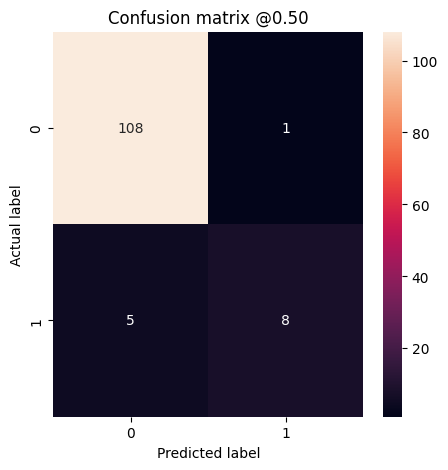

Correctly un-detected (True Negatives):  108
Incorrectly detected (False Positives):  1
Misses (False Negatives):  5
Hits (True Positives):  8
Total:  13
Accuracy: 0.95
Precision: 0.89
F1 Score: 0.73


In [21]:
# # evaluate predictions
test_predictions = loaded_model.predict(test_dm)
accuracy = accuracy_score(test_labels, np.rint(test_predictions))
accuracy = accuracy_score(test_labels, np.rint(test_predictions))
precision = precision_score(test_labels, np.rint(test_predictions))
f1 = f1_score(test_labels, np.rint(test_predictions))

p = 0.5
cm = confusion_matrix(test_labels, np.array(test_predictions) > p)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix @{:.2f}".format(p))
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()

if len(set(list(test_labels))) == 2:
    print("Correctly un-detected (True Negatives): ", cm[0][0])
    print("Incorrectly detected (False Positives): ", cm[0][1])
    print("Misses (False Negatives): ", cm[1][0])
    print("Hits (True Positives): ", cm[1][1])
    print("Total: ", np.sum(cm[1]))

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

Finally, we'll look at options for deploying this model.

---
## 6. Deploy

Now that we've trained a model, we can allow other applications to use it for inference by deploying it. SageMaker offers several deployment options, based on your performance, cost, and data needs:

![alt text](img/deployment_options.png "SageMaker Model Deployment Options")

### 6.1. Deploy Model as SageMaker Endpoint

Real-time inference endpoints are deployed to a persistent EC2 instance. This allows them to respond quickly to requests and support a wide range of custom properties. It's a good choice for models with steady usage. Deploying this endpoint will take about 5 minutes.

In [22]:
realtime_endpoint_name = f"her2-real-time-endpoint-{strftime('%Y-%m-%d-%H-%M-%S')}"

xgb_predictor = xgb_estimator.deploy(
    endpoint_name=realtime_endpoint_name,
    serializer=sagemaker.serializers.CSVSerializer(),  # Helper function to serialize ndarray into buffer
    deserializer=sagemaker.deserializers.JSONDeserializer(),  # Helper function to deserialize buffer into ndarray
    wait=True,
    instance_type="ml.t2.medium",  # Instance type we want to use to host our endpoint.
    initial_instance_count=1,  # For this example, we'll only use a single hosting instance.
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2022-12-16-15-09-37-233
INFO:sagemaker:Creating endpoint-config with name her2-real-time-endpoint-2022-12-16-15-09-37
INFO:sagemaker:Creating endpoint with name her2-real-time-endpoint-2022-12-16-15-09-37


---------!

### 6.2. Test Endpoint

In [23]:
# Load a random sample of 10 records from the test data
test_df = pd.read_csv("data/output/test/test.csv", header=None).sample(n=25)

# Submit the 10 samples to the inference endpoint and compare the actual and predicted values
print(
    f"Sending test traffic to the endpoint {xgb_predictor.endpoint_name}. \nPlease wait..."
)

for i, row in test_df.iterrows():
    print(
        f"[Actual | predicted] labels for record {i:3} are [{row[0]} | {xgb_predictor.predict([row.iloc[1:]])[0]:.3f}]"
    )
    sleep(0.1)

Sending test traffic to the endpoint her2-real-time-endpoint-2022-12-16-15-09-37. 
Please wait...
[Actual | predicted] labels for record  25 are [0.0 | 0.250]
[Actual | predicted] labels for record 115 are [0.0 | 0.003]
[Actual | predicted] labels for record  67 are [1.0 | 0.095]
[Actual | predicted] labels for record  23 are [0.0 | 0.014]
[Actual | predicted] labels for record  41 are [0.0 | 0.011]
[Actual | predicted] labels for record  98 are [0.0 | 0.009]
[Actual | predicted] labels for record  34 are [0.0 | 0.029]
[Actual | predicted] labels for record  90 are [0.0 | 0.023]
[Actual | predicted] labels for record  19 are [0.0 | 0.001]
[Actual | predicted] labels for record  51 are [0.0 | 0.051]
[Actual | predicted] labels for record  73 are [1.0 | 0.044]
[Actual | predicted] labels for record  11 are [0.0 | 0.015]
[Actual | predicted] labels for record  38 are [0.0 | 0.034]
[Actual | predicted] labels for record  89 are [0.0 | 0.001]
[Actual | predicted] labels for record 109 are [

### 6.3. Clean Up

In [25]:
# Delete endpoint
xgb_predictor.delete_endpoint()

# Delete all S3 objects
bucket = boto_session.resource("s3").Bucket(S3_BUCKET)
bucket.objects.filter().delete()

os.system("rm -rf data models generated training_reports")

INFO:sagemaker:Deleting endpoint configuration with name: her2-real-time-endpoint-2022-12-16-15-09-37
INFO:sagemaker:Deleting endpoint with name: her2-real-time-endpoint-2022-12-16-15-09-37


0